Program utworzony na podstawie rozwiązania dostępnego na stronie: https://keras.io/examples/vision/grad_cam/

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow import keras
import tensorflow as tf
model = ResNet50(weights='imagenet')

path = keras.utils.get_file(
    "water_buffalo.jpg", "https://i.imgur.com/FYO3iWN.jpeg"
)
img = image.load_img(path, target_size=(224, 224))
temp = image.img_to_array(img)
temp = np.expand_dims(temp, axis=0)
temp = preprocess_input(temp)

preds = model.predict(temp)

print('Predicted:', decode_predictions(preds, top=3)[0])

preprocess_input = temp

last_layer_name = "conv5_block3_2_relu"

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02408429', 'water_buffalo', 0.9972185), ('n02403003', 'ox', 0.0021606318), ('n02410509', 'bison', 0.00056571857)]


In [3]:
def get_array(path, size):

    img = keras.preprocessing.image.load_img(path, target_size=size)

    img_array = keras.preprocessing.image.img_to_array(img)

    array = np.expand_dims(img_array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layere, pred_index=None):

    gradcam_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layere).output, model.output]
    )


    with tf.GradientTape() as tape:
        last_layer_output, preds = gradcam_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    gradients = tape.gradient(class_channel, last_layer_output)

    pooled_gradients = tf.reduce_mean(gradients, axis=(0, 1, 2))

    last_layer_output = last_layer_output[0]
    heat_map = last_layer_output @ pooled_gradients[..., tf.newaxis]
    heat_map = tf.squeeze(heat_map)

    heat_map = tf.maximum(heat_map, 0) / tf.math.reduce_max(heat_map)
    return heat_map.numpy()

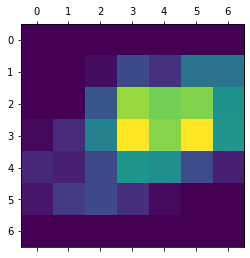

In [5]:
import matplotlib.pyplot as plt

img_size = (299, 299)
img_array = temp

# Make model
model = model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
#preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heat_map = make_gradcam_heatmap(img_array, model, last_layer_name)

# Display heatmap
plt.matshow(heat_map)
plt.show()

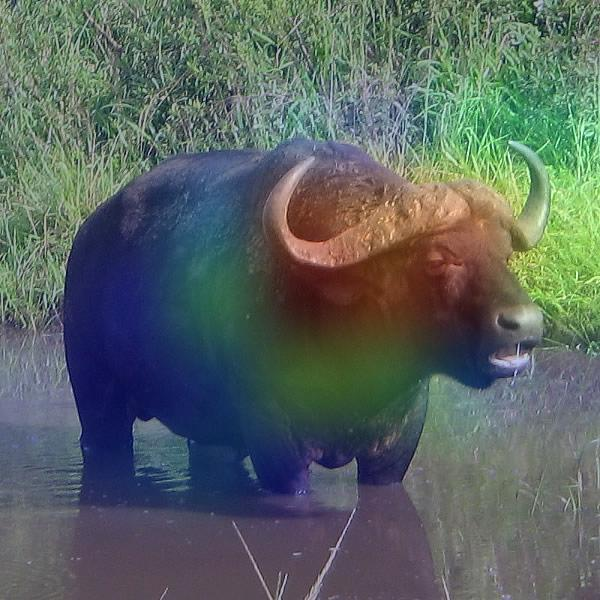

In [8]:
import matplotlib.cm as cm
from IPython.display import Image, display
def display_gradcam_image(path, heat_map, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(path)

    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heat_map = np.uint8(255 * heat_map)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heat_map = jet_colors[heat_map]

    # Create an image with RGB colorized heatmap
    jet_heat_map = keras.preprocessing.image.array_to_img(jet_heat_map)
    jet_heat_map = jet_heat_map.resize((img.shape[1], img.shape[0]))
    jet_heat_map = keras.preprocessing.image.img_to_array(jet_heat_map)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heat_map * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    # Display Grad CAM
    display(Image(cam_path))

    
display_gradcam_image(path, heat_map)

Scorecam